## Setup

In [150]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [43]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

np.set_printoptions(suppress=True)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# Defining constant variables
DRIVE_PATH = '/content/drive/MyDrive/Bundesliga/train.csv'
POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/'
NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Negatives/'
GRAY_POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/PositiveGray/'
GRAY_NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/NegativeGray/'

## Defining functions

In [98]:
def create_df_events():
  """Reads original DataFrame and creates antoher one with only relevant events"""
  df = pd.read_csv(DRIVE_PATH)
  df_events = df[~df['event_attributes'].isna()].copy()
  df_events.reset_index(drop=True, inplace=True)
  return df_events

In [102]:
def create_train_test_video_ids(df_events, train_size):
  """Creates two arrays with which videos are either part of the train or the test data"""
  video_ids = df_events['video_id'].unique().tolist()
  amount_videos = len(video_ids)
  amount_train = round(amount_videos * train_size)
  train_videos = video_ids[:amount_train]
  test_videos = video_ids[amount_train:]
  return video_ids, train_videos, test_videos

In [95]:
def create_X(video_ids, negatives, gray):
  """Creates X array with all pictures for both train and test data"""
  X = list()
  POS_PATH, NEG_PATH = POSITIVES_FOLDER_PATH, NEGATIVES_FOLDER_PATH
  if gray:
    POS_PATH, NEG_PATH = GRAY_POSITIVES_FOLDER_PATH, GRAY_NEGATIVES_FOLDER_PATH
  for video_id in video_ids:
    current_video = np.load(f'{POS_PATH}{video_id}.npz')
    current_video = current_video.f.arr_0
    X.append(current_video)
  if negatives:
    for video_id in video_ids: # [:-10]
      current_neg_video = np.load(f'{NEG_PATH}{video_id}.npz')
      current_neg_video = current_neg_video.f.arr_0
      X.append(current_neg_video)
  X = np.concatenate(X, axis=0)
  return X

In [94]:
def train_test_X_split(df_events, X, train_videos, test_videos):
  """Splits pictures in train and test data"""
  train_idx = df_events[df_events['video_id'].isin(train_videos)].index
  test_idx = df_events[df_events['video_id'].isin(test_videos)].index
  X_train = X[train_idx]
  X_test = X[test_idx]
  assert df_events.shape[0] == X_train.shape[0] + X_test.shape[0]
  return X_train, X_test, train_idx, test_idx

In [93]:
def train_test_y_split(df_events, train_idx, test_idx):
  """Creates DataFrame of labels for both train and test data using videos ids"""
  y_train = df_events[df_events.index.isin(train_idx)]['event'].to_frame()
  y_test = df_events[df_events.index.isin(test_idx)]['event'].to_frame()
  return y_train, y_test

In [92]:
def append_negatives(df_events, X, X_train, X_test, y_train, y_test, train_size):
  """Appends negative samples created to both train and both test datasets"""
  len_positives = df_events.shape[0]
  len_X = X.shape[0]
  len_negatives = len_X - len_positives

  START_IDX_NEGATIVES = df_events.shape[0]
  START_IDX_NEG_TEST = round(START_IDX_NEGATIVES + len_negatives * train_size)
  X_train_neg = X[START_IDX_NEGATIVES:START_IDX_NEG_TEST]
  X_test_neg = X[START_IDX_NEG_TEST:]
  assert len_negatives == X_train_neg.shape[0] + X_test_neg.shape[0]

  X_train = np.concatenate((X_train, X_train_neg), axis=0)
  X_test = np.concatenate((X_test, X_test_neg), axis=0)

  y_train = y_train.append(pd.DataFrame({'event':['negative'] * X_train_neg.shape[0]}))
  y_train.reset_index(drop=True, inplace=True)
  y_test = y_test.append(pd.DataFrame({'event':['negative'] * X_test_neg.shape[0]}))
  return X_train, X_test, y_train, y_test

In [91]:
def create_array_to_drop_for_undersampling_in_play(y_train):
  """Creates array of indexes to drop and perform undersampling in column 'play'"""
  play_indexes = y_train[y_train['event'] == 'play'].index
  assert y_train.value_counts()['play'] == len(play_indexes)
  play_amount = y_train.value_counts()['play']
  challenge_amount = y_train.value_counts()['challenge']
  drop_play_indexes = np.sort(np.random.choice(a=play_indexes, 
                                              size=play_amount - challenge_amount, 
                                              replace=False))
  assert len(drop_play_indexes) == play_amount - challenge_amount
  return drop_play_indexes

In [89]:
def perform_undersampling(X_train, y_train, drop_play_indexes):
  """Performs undersampling in 'play' category to balance it with 'challenge'"""
  X_train = np.delete(X_train, drop_play_indexes, axis=0) # Numpy array
  y_train.drop(drop_play_indexes, axis=0, inplace=True) # Pandas DataFrame
  return X_train, y_train

In [88]:
def perform_ohe(y_train, y_test):
  """Performs one-hot-encoding on our labels"""
  current_feat = ['event']
  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoder.fit(y_train[current_feat]) # Fit and transform data
  y_train[encoder.get_feature_names_out(list(current_feat))] = encoder.transform(y_train[current_feat])
  y_train = y_train.drop(columns=current_feat)

  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoder.fit(y_test[current_feat]) # Fit and transform data
  y_test[encoder.get_feature_names_out(list(current_feat))] = encoder.transform(y_test[current_feat])
  y_test = y_test.drop(columns=current_feat)
  return y_train, y_test

In [165]:
def train_val_split(X_train, y_train, train_size):
  """Splits train data into train and validation sets"""
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, random_state=0)
  return X_train, X_val, y_train, y_val

In [166]:
def del_X(X):
  """Deletes heavy variable X to free RAM"""
  del X

In [177]:
def preprocessing(train_test_ratio=0.75, train_val_ratio=0.8, negatives=True, undersampling=False, gray=False, free_ram=True):
  """Runs the whole pipeline before building the model"""
  df_events = create_df_events()
  video_ids, train_videos, test_videos = create_train_test_video_ids(df_events, train_test_ratio)
  X = create_X(video_ids, negatives, gray)
  X_train, X_test, train_idx, test_idx = train_test_X_split(df_events, X, train_videos, test_videos)
  y_train, y_test = train_test_y_split(df_events, train_idx, test_idx)
  if negatives:
    X_train, X_test, y_train, y_test = append_negatives(df_events, X, X_train, X_test, y_train, y_test, train_test_ratio)
  if undersampling:
    drop_play_indexes = create_array_to_drop_for_undersampling_in_play(y_train)
    X_train, y_train = perform_undersampling(X_train, y_train, drop_play_indexes)
  y_train, y_test = perform_ohe(y_train, y_test)
  X_train, X_val, y_train, y_val = train_val_split(X_train, y_train, train_val_ratio)
  if free_ram:
    del_X(X)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [136]:
def build_model(X_train, y_train, architecture='AlexNet'):
  """Builds CNN architecture of the model"""
  input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]
  num_classes = y_train.shape[1]

  if architecture == 'AlexNet':
    model = Sequential([
        Rescaling(1/255, 
                  input_shape=input_shape),  

        Conv2D(filters=96, 
               kernel_size=(11, 11), 
               strides=(4, 4), 
               activation='relu'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=256, 
               kernel_size=(5, 5),
               strides=(3, 3), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=256, 
               kernel_size=(3, 3),
               strides=(1, 1), 
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Flatten(),

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(num_classes, 
              activation='softmax')
        ])

    return model

In [115]:
def compile_model(model, optimizer='adam'):
  """Compiles the model"""
  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics='accuracy',
              )
  return model

In [192]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, patience=3):
  """Trains the model"""
  callback = EarlyStopping(monitor='val_loss',
                         patience=patience,
                         restore_best_weights=True
                         )

  model.fit(X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            batch_size=batch_size, 
            epochs=epochs,
            callbacks=[callback])
  
  return model

## Building 1st baseline model - with negatives and without undersampling

In [128]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing()

In [138]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3185, 480, 640, 3),
 (797, 480, 640, 3),
 (1120, 480, 640, 3),
 (3185, 4),
 (797, 4),
 (1120, 4))

In [137]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [139]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_25 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 58, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_26 (Bat  (None, 20, 26, 256)     

In [140]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
200/200 [==============================] - 353s 2s/step - loss: 1.1218 - accuracy: 0.6578 - val_loss: 0.8911 - val_accuracy: 0.6888
Epoch 2/100
200/200 [==============================] - 344s 2s/step - loss: 0.9626 - accuracy: 0.6989 - val_loss: 0.8806 - val_accuracy: 0.6901
Epoch 3/100
200/200 [==============================] - 346s 2s/step - loss: 0.9254 - accuracy: 0.7008 - val_loss: 0.8839 - val_accuracy: 0.6888
Epoch 4/100
200/200 [==============================] - 334s 2s/step - loss: 0.8964 - accuracy: 0.7071 - val_loss: 0.8823 - val_accuracy: 0.6964
Epoch 5/100
200/200 [==============================] - 349s 2s/step - loss: 0.8809 - accuracy: 0.7089 - val_loss: 0.8843 - val_accuracy: 0.6951


In [143]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              2240
                 1.0             0.0         0.0               447
1.0              0.0             0.0         0.0               405
0.0              0.0             0.0         1.0                93
dtype: int64

In [144]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              797
                 1.0             0.0         0.0              144
1.0              0.0             0.0         0.0              119
0.0              0.0             0.0         1.0               60
dtype: int64

In [145]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [146]:
y_pred_test = model.predict(X_test)

35/35 [==============================] - 32s 917ms/step


In [147]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

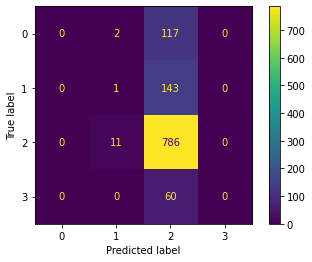

In [148]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [154]:
print(f"Macro F1 score: {f1_score(new_y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.2097


In [155]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

35/35 [==============================] - 28s 798ms/step - loss: 0.9953 - accuracy: 0.7027

Accuracy on the test set: 0.7027


In [156]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_1')

In [164]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_1')

## Building 2nd baseline model - with negatives and undersampling

In [157]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(undersampling=True)

In [160]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1358, 480, 640, 3),
 (340, 480, 640, 3),
 (1120, 480, 640, 3),
 (1358, 4),
 (340, 4),
 (1120, 4))

In [161]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [163]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
85/85 [==============================] - 159s 2s/step - loss: 1.7385 - accuracy: 0.3299 - val_loss: 1.2923 - val_accuracy: 0.3412
Epoch 2/100
85/85 [==============================] - 147s 2s/step - loss: 1.3104 - accuracy: 0.3387 - val_loss: 1.2839 - val_accuracy: 0.3147
Epoch 3/100
85/85 [==============================] - 143s 2s/step - loss: 1.2996 - accuracy: 0.3380 - val_loss: 1.2713 - val_accuracy: 0.3588
Epoch 4/100
85/85 [==============================] - 158s 2s/step - loss: 1.2760 - accuracy: 0.3623 - val_loss: 1.2653 - val_accuracy: 0.3529
Epoch 5/100
85/85 [==============================] - 145s 2s/step - loss: 1.2765 - accuracy: 0.3402 - val_loss: 1.2630 - val_accuracy: 0.3588
Epoch 6/100
85/85 [==============================] - 143s 2s/step - loss: 1.2534 - accuracy: 0.3292 - val_loss: 1.2629 - val_accuracy: 0.3588
Epoch 7/100
85/85 [==============================] - 141s 2s/step - loss: 1.2434 - accuracy: 0.3328 - val_loss: 1.2834 - val_accuracy: 0.3235
Epoch 

In [167]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              1.0             0.0         0.0              465
                 0.0             1.0         0.0              402
1.0              0.0             0.0         0.0              401
0.0              0.0             0.0         1.0               90
dtype: int64

In [168]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              797
                 1.0             0.0         0.0              144
1.0              0.0             0.0         0.0              119
0.0              0.0             0.0         1.0               60
dtype: int64

In [169]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [170]:
y_pred_test = model.predict(X_test)
y_pred_test

35/35 [==============================] - 27s 773ms/step


array([[0.00267016, 0.987425  , 0.00603648, 0.00386815],
       [0.00265423, 0.9873436 , 0.00611001, 0.00389227],
       [0.0039089 , 0.9808896 , 0.00985101, 0.00535036],
       ...,
       [0.29665706, 0.31993678, 0.29723728, 0.08616886],
       [0.2871848 , 0.33717072, 0.28238067, 0.09326389],
       [0.2772716 , 0.34768862, 0.29145598, 0.08358379]], dtype=float32)

In [171]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

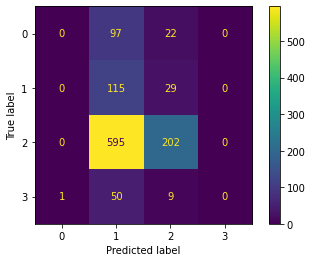

In [172]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [173]:
print(f"Macro F1 score: {f1_score(new_y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.1528


In [174]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

35/35 [==============================] - 27s 783ms/step - loss: 2.3058 - accuracy: 0.2830

Accuracy on the test set: 0.2830


In [175]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

## Building 3rd baseline model - with gray, with negatives, and with undersampling

In [196]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(undersampling=True, gray=True, train_test_ratio=0.83)

In [197]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1455, 480, 640, 3),
 (364, 480, 640, 3),
 (793, 480, 640, 3),
 (1455, 4),
 (364, 4),
 (793, 4))

In [117]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [119]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
90/90 [==============================] - 148s 2s/step - loss: 1.7618 - accuracy: 0.2937 - val_loss: 1.3163 - val_accuracy: 0.3278
Epoch 2/100
90/90 [==============================] - 147s 2s/step - loss: 1.3327 - accuracy: 0.3145 - val_loss: 1.3381 - val_accuracy: 0.3194
Epoch 3/100
90/90 [==============================] - 157s 2s/step - loss: 1.3067 - accuracy: 0.3396 - val_loss: 1.3208 - val_accuracy: 0.3167
Epoch 4/100
90/90 [==============================] - 145s 2s/step - loss: 1.3015 - accuracy: 0.3375 - val_loss: 1.3118 - val_accuracy: 0.2667
Epoch 5/100
90/90 [==============================] - 145s 2s/step - loss: 1.2789 - accuracy: 0.3354 - val_loss: 1.3108 - val_accuracy: 0.2972
Epoch 6/100
90/90 [==============================] - 144s 2s/step - loss: 1.2765 - accuracy: 0.3312 - val_loss: 1.3470 - val_accuracy: 0.2972
Epoch 7/100
90/90 [==============================] - 153s 2s/step - loss: 1.2743 - accuracy: 0.3396 - val_loss: 1.3098 - val_accuracy: 0.3139
Epoch 

In [199]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [200]:
y_pred_test = model.predict(X_test)

25/25 [==============================] - 19s 747ms/step


In [201]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

In [202]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              1.0             0.0         0.0              477
                 0.0             1.0         0.0              436
1.0              0.0             0.0         0.0              430
0.0              0.0             0.0         1.0              112
dtype: int64

In [203]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              556
                 1.0             0.0         0.0              122
1.0              0.0             0.0         0.0               84
0.0              0.0             0.0         1.0               31
dtype: int64

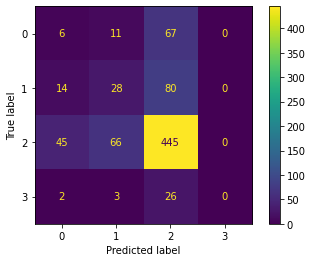

In [204]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [205]:
print(f"Macro F1 score: {f1_score(new_y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.2703


In [198]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

25/25 [==============================] - 19s 752ms/step - loss: 1.2495 - accuracy: 0.6040

Accuracy on the test set: 0.6040


In [190]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_3')

In [193]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_3')